In [1]:
import matplotlib.pyplot as plt



In [2]:
from __future__ import print_function
import cv2
import numpy as np
from matplotlib import pyplot as plt

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

In [3]:
refFilename = "./temp_data/8.jpg"
im = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB )

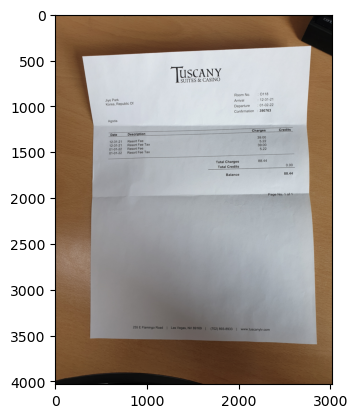

In [4]:
plt.imshow(im)

In [5]:
#path = "/Users/Harshil/Downloads/"
#refFilename = "./temp_data/6.jpg"
image = cv2.imread(refFilename)

In [6]:
#https://levelup.gitconnected.com/create-your-own-camscanner-using-python-opencv-2dd8355432de

In [8]:
import numpy as np
import cv2
import re
from matplotlib import pyplot as plt


# ## **Use Gaussian Blurring combined with Adaptive Threshold**

def blur_and_threshold(gray):
    gray = cv2.GaussianBlur(gray, (3, 3), 2)
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    threshold = cv2.fastNlMeansDenoising(threshold, 11, 31, 9)
    return threshold


# ## **Find the Biggest Contour**

# **Note: We made sure the minimum contour is bigger than 1/10 size of the whole picture. This helps in removing very small contours (noise) from our dataset**


def biggest_contour(contours, min_area):
    biggest = None
    max_area = 0
    biggest_n = 0
    approx_contour = None
    for n, i in enumerate(contours):
        area = cv2.contourArea(i)

        if area > min_area / 30:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
                biggest_n = n
                approx_contour = approx

    return biggest_n, approx_contour


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    pts = pts.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


# ## Find the exact (x,y) coordinates of the biggest contour and crop it out


def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped


# # Transformation the image

# **1. Convert the image to grayscale**

# **2. Remove noise and smoothen out the image by applying blurring and thresholding techniques**

# **3. Use Canny Edge Detection to find the edges**

# **4. Find the biggest contour and crop it out**


def transformation(image):
    image = image.copy()

    height, width, channels = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_size = gray.size

    threshold = blur_and_threshold(gray)
    # We need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal
    # are sure to be edges and those below minVal are sure to be non-edges, so discarded.
    #  Those who lie between these two thresholds are classified edges or non-edges based on their connectivity.
    # If they are connected to "sure-edge" pixels, they are considered to be part of edges.
    #  Otherwise, they are also discarded
    edges = cv2.Canny(threshold, 50, 150, apertureSize=7)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    simplified_contours = []

    for cnt in contours:
        hull = cv2.convexHull(cnt)
        simplified_contours.append(cv2.approxPolyDP(hull,
                                                    0.001 * cv2.arcLength(hull, True), True))
    simplified_contours = np.array(simplified_contours)
    biggest_n, approx_contour = biggest_contour(simplified_contours, image_size)

    threshold = cv2.drawContours(image, simplified_contours, biggest_n, (0, 255, 0), 1)

    dst = 0
    if approx_contour is not None and len(approx_contour) == 4:
        approx_contour = np.float32(approx_contour)
        dst = four_point_transform(threshold, approx_contour)
    croppedImage = dst
    return croppedImage


# **Increase the brightness of the image by playing with the "V" value (from HSV)**

def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


# **Sharpen the image using Kernel Sharpening Technique**


def final_image(rotated):
    # Create our shapening kernel, it must equal to one eventually
    kernel_sharpening = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    # applying the sharpening kernel to the input image & displaying it.
    sharpened = cv2.filter2D(rotated, -1, kernel_sharpening)
    sharpened = increase_brightness(sharpened, 30)
    return sharpened


# ## 1. Pass the image through the transformation function to crop out the biggest contour

# ## 2. Brighten & Sharpen the image to get a final cleaned image
#cv2.imwrite(path + "Final_Image2.jpg", cleaned_image)

In [9]:

# img_grey = cv2.cvtColor(cleaned_image, cv2.COLOR_BGR2GRAY)
# img_grey = img_grey.astype('uint8')

In [10]:
# thresh = cv2.adaptiveThreshold(img_grey, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
# thresh = cv2.cvtColor(cleaned_image, cv2.COLOR_GRAY2RGB)

C:\Users\user\AppData\Local\Temp\ipykernel_54396\3664232352.py:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  simplified_contours = np.array(simplified_contours)


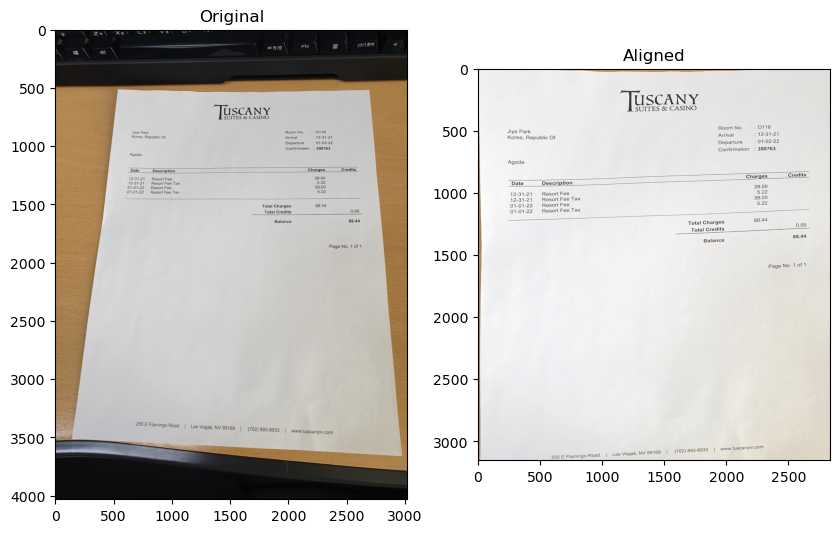

In [11]:
refFilename = "./temp_data/0.jpg"
image = cv2.imread(refFilename)

im_blur = transformation(image)
im_clean = final_image(im_blur)

f, axarr = plt.subplots(1,2, figsize=(10,7))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im_clean = cv2.cvtColor(im_clean, cv2.COLOR_BGR2RGB)
axarr[0].imshow(image)
axarr[0].title.set_text('Original')

axarr[1].imshow(im_clean)
axarr[1].title.set_text('Aligned')

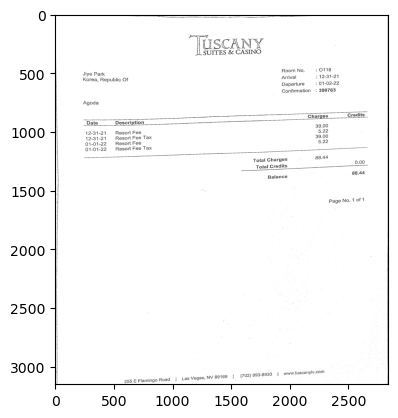

In [121]:
warped = cv2.cvtColor(im_clean, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
plt.imshow(warped, cmap='gray')

C:\Users\user\AppData\Local\Temp\ipykernel_6292\3264271785.py:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  simplified_contours = np.array(simplified_contours)


<IPython.core.display.Javascript object>


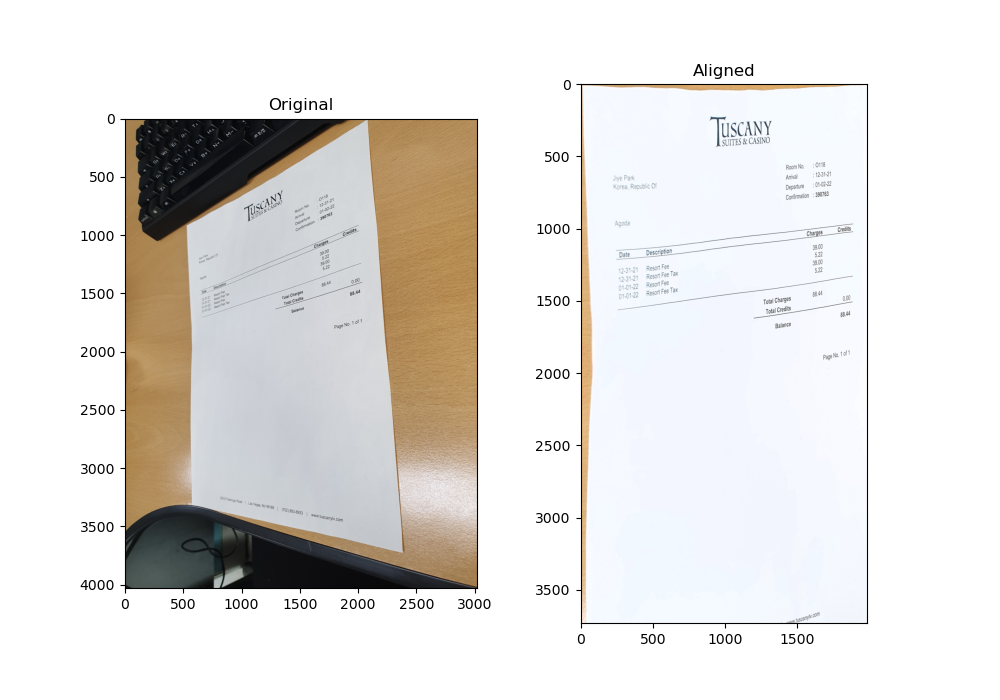

In [111]:
refFilename = "./temp_data/1.jpg"
image = cv2.imread(refFilename)

im_blur = transformation(image)
im_clean = final_image(im_blur)

f, axarr = plt.subplots(1,2, figsize=(10,7))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im_clean = cv2.cvtColor(im_clean, cv2.COLOR_BGR2RGB)
axarr[0].imshow(image)
axarr[0].title.set_text('Original')

axarr[1].imshow(im_clean)
axarr[1].title.set_text('Aligned')

C:\Users\user\AppData\Local\Temp\ipykernel_6292\3664232352.py:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  simplified_contours = np.array(simplified_contours)


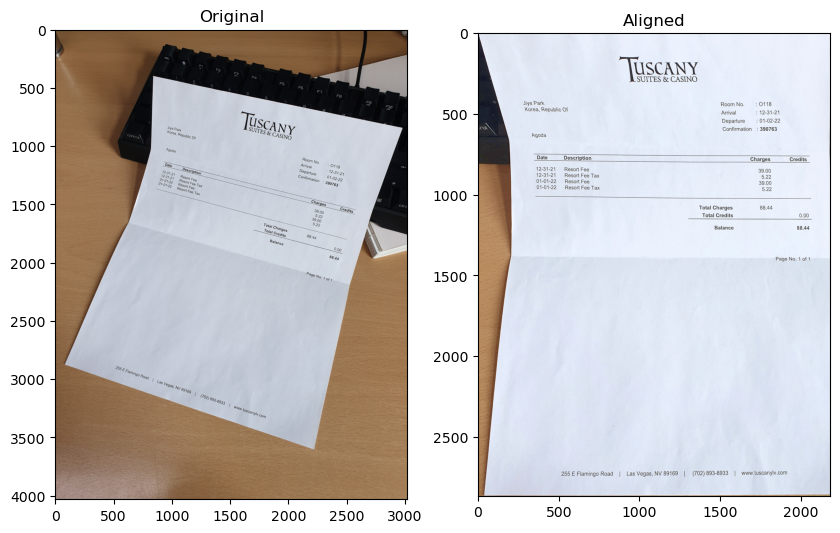

In [100]:
refFilename = "./temp_data/6.jpg"
image = cv2.imread(refFilename)

im_blur = transformation(image)
im_clean = final_image(im_blur)

f, axarr = plt.subplots(1,2, figsize=(10,7))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im_clean = cv2.cvtColor(im_clean, cv2.COLOR_BGR2RGB)
axarr[0].imshow(image)
axarr[0].title.set_text('Original')

axarr[1].imshow(im_clean)
axarr[1].title.set_text('Aligned')

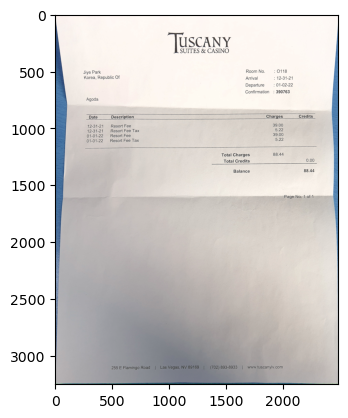

In [101]:
plt.imshow(cleaned_image)

In [114]:
from skimage.filters import threshold_local
#%matplotlib notebook
%matplotlib inline


In [117]:
warped = cv2.cvtColor(cleaned_image, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
plt.imshow(warped, cmap='gray')

In [ ]:
#https://pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/

In [76]:
from __future__ import print_function
import cv2
import numpy as np
 
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
 
def alignImages(im1, im2):

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h
 


IndentationError: expected an indented block (1693623126.py, line 39)

In [ ]:
if __name__ == '__main__':

    # Read reference image
    refFilename = "form.jpg"
    print("Reading reference image : ", refFilename)
    imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

    # Read image to be aligned
    imFilename = "scanned-form.jpg"
    print("Reading image to align : ", imFilename);
    im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

    print("Aligning images ...")
    # Registered image will be resotred in imReg.
    # The estimated homography will be stored in h.
    imReg, h = alignImages(im, imReference)

    # Write aligned image to disk.
    outFilename = "aligned.jpg"
    print("Saving aligned image : ", outFilename);
    cv2.imwrite(outFilename, imReg)

    # Print estimated homography
    print("Estimated homography : \n",  h)

In [ ]:
import cv2
import numpy as np

img = cv2.imread('flower.jpg', 1)
# converting to LAB color space
lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, a, b = cv2.split(lab)

# Applying CLAHE to L-channel
# feel free to try different values for the limit and grid size:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(l_channel)

# merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))

# Converting image from LAB Color model to BGR color spcae
enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Stacking the original image with the enhanced image
result = np.hstack((img, enhanced_img))
cv2.imshow('Result', result)